# Relatório final de churn

Este relatório sintetiza o fluxo de modelagem, métricas e fatores que mais influenciam a evasão.

In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline

sys.path.append("..")

from src.ml_pipeline import load_dataset, split_features_target, build_preprocessor, train_test_split_stratified, extract_feature_names

sns.set_theme(style="whitegrid")

In [2]:
data_path = "../data/processed/churn_final.csv"
df = load_dataset(data_path)

target_col = "churn_binary"
drop_cols = ["customerID", "Churn", target_col]

x, y = split_features_target(df, target_col, drop_cols)

categorical_cols = x.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = x.select_dtypes(include=[np.number]).columns.tolist()

preprocessor = build_preprocessor(categorical_cols, numeric_cols)
splits = train_test_split_stratified(x, y, test_size=0.2, random_state=42)

In [3]:
model = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced",
)

pipeline = Pipeline(
    [
        ("preprocess", preprocessor),
        ("model", model),
    ]
)

pipeline.fit(splits.x_train, splits.y_train)
pred = pipeline.predict(splits.x_test)
prob = pipeline.predict_proba(splits.x_test)[:, 1]

In [4]:
metrics = {
    "accuracy": accuracy_score(splits.y_test, pred),
    "precision": precision_score(splits.y_test, pred),
    "recall": recall_score(splits.y_test, pred),
    "f1": f1_score(splits.y_test, pred),
    "roc_auc": roc_auc_score(splits.y_test, prob),
}

pd.DataFrame([metrics])

,accuracy,precision,recall,f1,roc_auc
0,0.777854,0.583607,0.475936,0.5243,0.820935


In [5]:
feature_names = extract_feature_names(preprocessor, categorical_cols, numeric_cols)
importances = pipeline.named_steps["model"].feature_importances_

importance_df = (
    pd.DataFrame({"feature": feature_names, "importance": importances})
    .sort_values(by="importance", ascending=False)
    .head(15)
)

importance_df

,feature,importance
44,account.Charges.Total,0.105457
46,avg_monthly_charge,0.092918
43,account.Charges.Monthly,0.091455
42,customer.tenure,0.091082
45,tenure_months,0.086604
32,account.Contract_Month-to-month,0.061673
34,account.Contract_Two year,0.033905
14,internet.OnlineSecurity_No,0.031149
23,internet.TechSupport_No,0.027803
47,service_count,0.024836


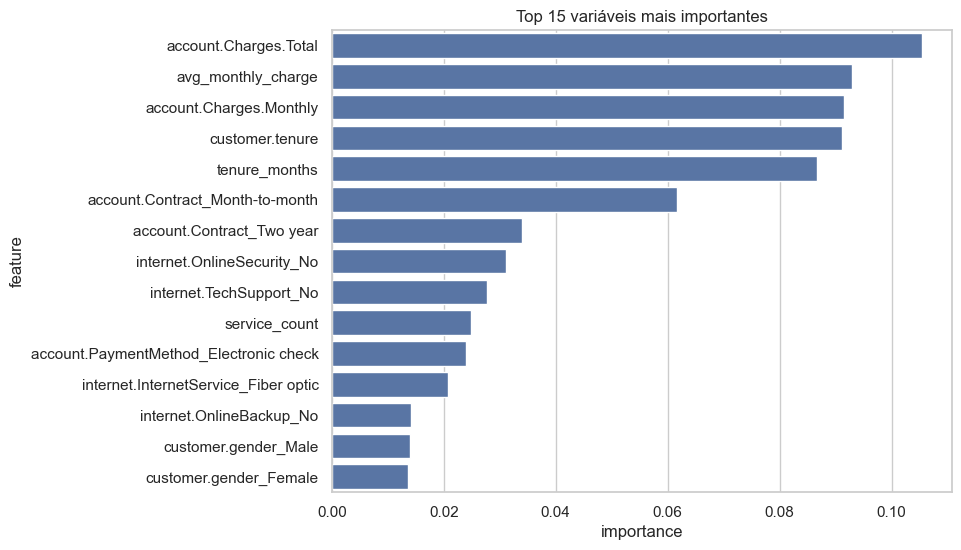

In [6]:
plt.figure(figsize=(8, 6))
sns.barplot(data=importance_df, x="importance", y="feature", orient="h")
plt.title("Top 15 variáveis mais importantes")
plt.show()

## Conclusões de negócio

- Variáveis relacionadas a tipo de contrato e forma de pagamento costumam aparecer entre as mais relevantes.
- Clientes com contratos mensais e cobranças mais altas tendem a maior risco de churn.
- Serviços adicionais como suporte técnico e segurança podem reduzir a evasão.